## Imports

In [1]:
import ast
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVR
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer



## Global variables

In [2]:
scaler = MinMaxScaler()

# One hot encoding
genres_mlb = MultiLabelBinarizer()
spoken_languages_mlb = MultiLabelBinarizer()
production_countries_mlb = MultiLabelBinarizer()

# Label encoding
original_language_encoder = LabelEncoder()
status_encoder = LabelEncoder()
name_encoder = LabelEncoder()
character_encoder = LabelEncoder()

# Hashing encoding
keywords_hash_num = 30    #Change this Number for more accuracy
keywords_hash_columns = []
hash_column_name = ''

for i in range(keywords_hash_num):
  hash_column_name = 'keywords_hash_' + str(i)
  keywords_hash_columns.append(hash_column_name)

keywords_hasher = FeatureHasher(n_features=keywords_hash_num, input_type='string')


production_companies_hash_num = 20 #Change this Number for more accuracy
production_companies_hash_columns = []
hash_column_name = ''

for i in range(production_companies_hash_num):
  hash_column_name = 'production_companies_hash_' + str(i)
  production_companies_hash_columns.append(hash_column_name)

production_companies_hasher = FeatureHasher(n_features=production_companies_hash_num, input_type='string')


tfidf  = TfidfVectorizer(stop_words='english')


cast_num = 1  
cast_columns = []
cast_character = ''
cast_gender = ''
cast_name = ''
cast_order = ''

for i in range(cast_num):
  cast_character = 'cast_' + str(i) + '_character'
  cast_gender = 'cast_' + str(i) + '_gender'
  cast_name = 'cast_' + str(i) + '_name'
  cast_order = 'cast_' + str(i) + '_order'

  cast_columns.append(cast_character)
  cast_columns.append(cast_gender)
  cast_columns.append(cast_name)
  cast_columns.append(cast_order)


missingValues = {
    'budget'  :  None,
    'genres'  :  None,
    'homepage'  :  None,
    'id'  :  None,
    'keywords'  :  None,
    'original_language'  :  None,
    'original_title'  :  None,
    'overview'  :  None,
    'viewercount'  :  None,
    'production_companies'  :  None,
    'production_countries'  :  None,
    'release_date'  :  None,
    'revenue'  :  None,
    'runtime'  :  None,
    'spoken_languages'  :  None,
    'status'  :  None,
    'tagline'  :  None,
    'title'  :  None,
    'vote_count'  :  None,
    'cast'  :  None,
    'crew'  :  None,
}


## Helper functions

### Save the models

In [3]:

# Save the encoding objects
def save_encoders(encoding):
    with open('encoders.pkl', 'wb') as file:
        pickle.dump(encoding, file)

# Save the feature hashers
def save_hashers(hash):
    with open('hashers.pkl', 'wb') as file:
        pickle.dump(hash, file)

# Save the TF-IDF vectorizer
def save_tfidf_vectorizer(tf_idf):
    with open('tfidf_vectorizer.pkl', 'wb') as file:
        pickle.dump(tf_idf, file)

# Save the scalers
def save_scalers(scale):
    with open('scalers.pkl', 'wb') as file:
        pickle.dump(scale, file)

# Save the feature selection
def save_feature_selection(feature):
    with open('feature_selection.pkl', 'wb') as file:
        pickle.dump(feature, file)

# Save the model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


  
# Save the missing values
def save_missing_values(missingValues):
    with open('missing_values.pkl', 'wb') as file:
        pickle.dump(missingValues, file)
     



### Load the models

In [4]:

# Load the encoding objects
def load_encoders():
    with open('encoders.pkl', 'rb') as file:
        encodings = pickle.load(file)

        
    genres_mlb = encodings['genres_mlb']
    spoken_languages_mlb = encodings['spoken_languages_mlb']
    production_countries_mlb = encodings['production_countries_mlb']
    original_language_encoder = encodings['original_language_encoder']
    status_encoder = encodings['status_encoder']
    name_encoder = encodings['name_encoder']
    character_encoder = encodings['character_encoder']
    
    return genres_mlb, spoken_languages_mlb, production_countries_mlb, original_language_encoder, status_encoder, name_encoder, character_encoder

# Load the feature hashers
def load_hashers():
    with open('hashers.pkl', 'rb') as file:
        hashing = pickle.load(file)

    keywords_hasher = hashing['keywords_hasher']
    production_companies_hasher = hashing['production_companies_hasher']

    return keywords_hasher, production_companies_hasher
    

# Load the TF-IDF vectorizer
def load_tfidf_vectorizer():
    with open('tfidf_vectorizer.pkl', 'rb') as file:
        return pickle.load(file)


# Load the scalers
def load_scalers():
    with open('scalers.pkl', 'rb') as file:
        return pickle.load(file)

# Load the feature selection
def load_feature_selection():
    with open('feature_selection.pkl', 'rb') as file:
        return pickle.load(file)

# Load the models
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)
    
# Load the missing values
def load_missing_values():
    with open('missing_values.pkl', 'rb') as file:
        return pickle.load(file)



### Adding a new label in label encoding

In [5]:
def unseen(data, encoder, columnName):
    unseen_values = list(set(data[columnName]) - set(encoder.classes_))
    if unseen_values:
        for unseen in unseen_values:
            if unseen not in encoder.classes_:
                new_label = max(encoder.transform(encoder.classes_)) + 1
                encoder.classes_ = np.append(encoder.classes_, unseen)
                encoder.transform([unseen])[0] = new_label



### Converting list of dictionaries to normal list of elements


In [6]:
def transformColumn(enteredData, columnName, dictionaryKey):
    enteredData[columnName] = [ast.literal_eval(row) for row in enteredData[columnName]]
    for index, row in enteredData[columnName].items():
        finalList = []
        for j in range(len(row)):
            finalList.append(row[j][dictionaryKey])
        enteredData.at[index, columnName] = finalList


In [7]:
def transformMoviesColumns(enteredData, columnName, dictionaryKey1, dictionaryKey2, dictionaryKey3, dictionaryKey4):
  enteredData[columnName] = [ast.literal_eval(row) for row in enteredData[columnName]]
  for index, row in enteredData[columnName].items():
    finalList = []
    for j in range(len(row)):
      fList = []
      fList.append(row[j][dictionaryKey1])
      fList.append(row[j][dictionaryKey2])
      fList.append(row[j][dictionaryKey3])
      fList.append(row[j][dictionaryKey4])
      finalList.append(fList)
    enteredData.at[index, columnName] = finalList


### Filling missing values

#### Filling missing values in numerical columns with mean value


In [8]:
def fillNumericalData(enteredData, columnName):
  mean_val = np.mean(enteredData[enteredData[columnName] != 0][columnName])
  enteredData[columnName] = enteredData[columnName].replace(0, mean_val)
  missingValues[columnName] = mean_val
  enteredData[columnName] =  enteredData[columnName].fillna(mean_val)


#### Filling missing values in categoral columns with mod category 


In [9]:
def fillCategoralData(enteredData, columnName):
    list_counter = Counter(tuple(lst) for lst in enteredData[columnName])
    mode_list = list(max(list_counter, key=list_counter.get))
    if not mode_list:
        mode_list = list(sorted(list_counter, key=list_counter.get, reverse=True)[1])
    enteredData[columnName] = enteredData[columnName].apply(lambda x: x if x else mode_list)
    missingValues[columnName] = mode_list



In [10]:
def fillMoviesCategoralData(enteredData, columnName):
    tuple_counter = Counter(tuple(inner_lst) for lst in enteredData[columnName] for inner_lst in lst)
    mode_tuple = max(tuple_counter, key=tuple_counter.get)
    mode_list = [list(mode_tuple)]
    if not mode_list:
        mode_list = [list(sorted(tuple_counter, key=tuple_counter.get, reverse=True)[1])]
    enteredData[columnName] = enteredData[columnName].apply(lambda lst: lst if lst else mode_list)
    missingValues[columnName] = mode_list



### Preprocessing to the non-models 

In [11]:

def nonModels_preprocessing(data):
    # converting list of dectionaries to normal lists of elements using "transformColumn" function
    # genres column
    transformColumn(data, 'genres', 'name')
    # keywords column
    transformColumn(data, 'keywords', 'name')
    # production_companies column
    transformColumn(data, 'production_companies', 'name')
    # production_countries column
    transformColumn(data, 'production_countries', 'name')
    # spoken_languages column
    transformColumn(data, 'spoken_languages', 'iso_639_1')
    # cast column
    transformMoviesColumns(data, 'cast', 'character', 'gender', 'name', 'order')
    # crew column
    transformMoviesColumns(data, 'crew', 'name', 'department', 'gender', 'job')

    # Only leaving the year from the release date column
    data['release_date'] = data['release_date'].str[-4:].astype(int)
    
    # fill missing values of categoral data with mod category using "fillCategoralData" function
    # genres column
    fillCategoralData(data, 'genres')
    # keywords column
    fillCategoralData(data, 'keywords')
    # spoken_languages column
    fillCategoralData(data, 'spoken_languages')
    # production_companies column
    fillCategoralData(data, 'production_companies')
    # production_countries column
    fillCategoralData(data, 'production_countries')
    # cast column
    fillMoviesCategoralData(data, 'cast')
    # crew column
    fillMoviesCategoralData(data, 'crew')

    # fill missing values in numerical columns with mean value in column 
    # budget column
    fillNumericalData(data, 'budget')
    # id column
    fillNumericalData(data, 'id')
    # viewercount column
    fillNumericalData(data, 'viewercount')
    # release_date column
    fillNumericalData(data, 'release_date')
    # revenue column
    fillNumericalData(data, 'revenue')
    # runtime column
    fillNumericalData(data, 'runtime')
    # vote_count column
    fillNumericalData(data, 'vote_count')
   

    # fill missing values in textual columns with mod value in column
    # homepage column
    missingValues['homepage'] = (data['homepage'].mode()[0])
    data['homepage'] = data['homepage'].fillna(data['homepage'].mode()[0])
    
    # tagline column
    missingValues['tagline'] = (data['tagline'].mode()[0])
    data['tagline'] = data['tagline'].fillna(data['tagline'].mode()[0])
    
    # overview column
    missingValues['overview'] = (data['overview'].mode()[0])
    data['overview'] = data['overview'].fillna(data['overview'].mode()[0])
    
    # original_language column
    missingValues['original_language'] = (data['original_language'].mode()[0])
    data['original_language'] =  data['original_language'].fillna(data['original_language'].mode()[0])
    
    # original_title column
    missingValues['original_title'] = (data['original_title'].mode()[0])
    data['original_title'] =  data['original_title'].fillna(data['original_title'].mode()[0])
    
    # status column
    missingValues['status'] = (data['status'].mode()[0])
    data['status'] =  data['status'].fillna(data['status'].mode()[0])
    
    # status column
    missingValues['title'] = (data['title'].mode()[0])
    data['title'] =  data['title'].fillna(data['title'].mode()[0])



    # Placing the values from the cast column to a column of it's own  
    data = data.join(pd.DataFrame(columns=cast_columns, index = data.index))
    for index, row in data.iterrows():
      k = 0
      for j in range(cast_num):
        if(j > len(row['cast']) - 1):
          break 
        data.at[index, cast_columns[k]] = row['cast'][j][0]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][1]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][2]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][3]
        k += 1

    data.drop('cast',axis=1,inplace=True)
    
    return data


In [12]:

def fillMissingTestData(data):
    missingValues = load_missing_values()
    
    categoralColumns = ['genres', 'keywords', 'spoken_languages',
                        'production_companies', 'production_countries', 'cast', 'crew']
    for i in categoralColumns:
        data[i] = data[i].apply(lambda x: x if x else missingValues[i])
   
    numericalColumns = ['budget', 'id', 'viewercount',
                    'release_date', 'revenue', 'runtime', 'vote_count']
    for i in numericalColumns:
        data[i] = data[i].replace(0, missingValues[i])
        data[i] =  data[i].fillna(missingValues[i])

    textualColumns = ['homepage', 'original_title', 'tagline',
                      'title', 'status', 'overview', 'original_language']
    for i in textualColumns:
        data[i] =  data[i].fillna(missingValues[i])

    return data
    


In [13]:

def nonModels_preprocessing_script(data):
    # converting list of dectionaries to normal lists of elements using "transformColumn" function
    # genres column
    transformColumn(data, 'genres', 'name')
    # keywords column
    transformColumn(data, 'keywords', 'name')
    # production_companies column
    transformColumn(data, 'production_companies', 'name')
    # production_countries column
    transformColumn(data, 'production_countries', 'name')
    # spoken_languages column
    transformColumn(data, 'spoken_languages', 'iso_639_1')
    # cast column
    transformMoviesColumns(data, 'cast', 'character', 'gender', 'name', 'order')
    # crew column
    transformMoviesColumns(data, 'crew', 'name', 'department', 'gender', 'job')

    # Only leaving the year from the release date column
    data['release_date'] = data['release_date'].str[-4:].astype(int)

    data = fillMissingTestData(data)

    # Placing the values from the cast column to a column of it's own  
    data = data.join(pd.DataFrame(columns=cast_columns, index = data.index))
    for index, row in data.iterrows():
      k = 0
      for j in range(cast_num):
        if(j > len(row['cast']) - 1):
          break 
        data.at[index, cast_columns[k]] = row['cast'][j][0]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][1]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][2]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][3]
        k += 1

    data.drop('cast',axis=1,inplace=True)
    
    
    return data


## Load data

In [14]:
data = pd.read_csv('movies-regression-dataset.csv')
X = data.iloc[:, :19] 
Y = data['vote_average']
movies = pd.read_csv('movies-credit-students-train.csv')


## Add the cast and crew columns to X dataFrame

In [15]:
def join_columns(data, movies):
  # Add two empty columns to the DataFrame
  data = data.join(pd.DataFrame(movies['cast'], columns=['cast'], index = data.index))
  data = data.join(pd.DataFrame(movies['crew'], columns=['crew'], index = data.index))

  # Put the cast and crew in the right cells
  for dataIndex, dataRow in data.iterrows():
    if dataRow['id'] in movies['movie_id'].values:
      index = movies.loc[movies['movie_id'] == dataRow['id']].index[0]
      data.at[dataIndex, 'cast'] = movies.at[index, 'cast']
      data.at[dataIndex, 'crew'] = movies.at[index, 'crew']
    else:
      data.at[dataIndex, 'cast'] = '[]'
      data.at[dataIndex, 'crew'] = '[]'
  
  return data


## Explaratory data analysis


### View data

In [16]:
print(data.head())

     budget                                             genres  \
0  25000000  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
1  38000000  [{"id": 878, "name": "Science Fiction"}, {"id"...   
2  20000000  [{"id": 36, "name": "History"}, {"id": 18, "na...   
3  23000000  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
4  52000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   

                                homepage     id  \
0    http://www.maoslastdancermovie.com/  33870   
1                                    NaN    193   
2    http://focusfeatures.com/film/milk/  10139   
3                                    NaN  11632   
4  http://www.frompariswithlovefilm.com/  26389   

                                            keywords original_language  \
0  [{"id": 4328, "name": "costume"}, {"id": 4528,...                en   
1  [{"id": 10988, "name": "based on tv series"}, ...                en   
2  [{"id": 237, "name": "gay"}, {"id": 582, "name...                en   


### Data Info

In [17]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3039 non-null   int64  
 1   genres                3039 non-null   object 
 2   homepage              1129 non-null   object 
 3   id                    3039 non-null   int64  
 4   keywords              3039 non-null   object 
 5   original_language     3039 non-null   object 
 6   original_title        3039 non-null   object 
 7   overview              3038 non-null   object 
 8   viewercount           3039 non-null   float64
 9   production_companies  3039 non-null   object 
 10  production_countries  3039 non-null   object 
 11  release_date          3039 non-null   object 
 12  revenue               3039 non-null   int64  
 13  runtime               3038 non-null   float64
 14  spoken_languages      3039 non-null   object 
 15  status               

### Data Disctription

In [18]:
print(data.describe())

             budget             id  viewercount       revenue      runtime  \
count  3.039000e+03    3039.000000  3039.000000  3.039000e+03  3038.000000   
mean   3.571232e+07   46828.696282    24.600176  9.834350e+07   109.781106   
std    4.171020e+07   77988.231888    33.686634  1.727191e+08    20.951969   
min    0.000000e+00       5.000000     0.000372  0.000000e+00     0.000000   
25%    7.750000e+06    8370.000000     7.341400  1.068736e+06    96.000000   
50%    2.200000e+07   12201.000000    16.234053  3.548561e+07   106.000000   
75%    5.000000e+07   44736.000000    31.459205  1.155541e+08   120.000000   
max    2.800000e+08  447027.000000   875.581305  2.787965e+09   338.000000   

         vote_count  vote_average  
count   3039.000000   3039.000000  
mean     802.360974      6.188417  
std     1296.617065      0.916945  
min        0.000000      0.000000  
25%       99.500000      5.600000  
50%      325.000000      6.200000  
75%      907.000000      6.800000  
max    13

### Find Duplicates Values 

In [19]:
print(data.duplicated().sum())

0


### Find Missing Values


In [20]:
print(data.isna().sum())

budget                     0
genres                     0
homepage                1910
id                         0
keywords                   0
original_language          0
original_title             0
overview                   1
viewercount                0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    1
spoken_languages           0
status                     0
tagline                  383
title                      0
vote_count                 0
vote_average               0
dtype: int64


### Distribution of the vote_average rating

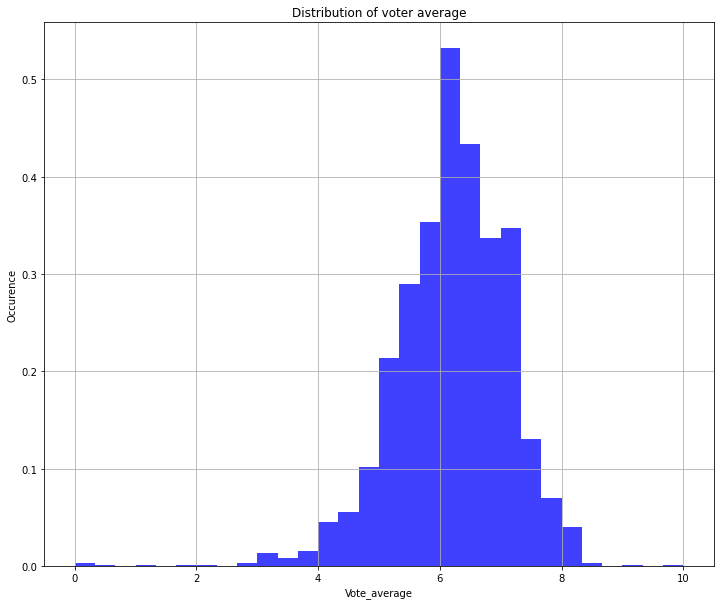

Minimum of Ratings: 0.0
Maximum of Ratings: 10.0
Average of Ratings: 6.19
Variance of Ratings: 0.84


In [21]:
plt.subplots(figsize=(12,10))
n, bins, patches = plt.hist(Y, 30, density=1, facecolor='b', alpha=0.75)

plt.xlabel('Vote_average')
plt.ylabel('Occurence')
plt.title('Distribution of voter average')
plt.grid(True)
plt.show()
print("Minimum of Ratings:", round(min(data['vote_average']),2))
print("Maximum of Ratings:", round(max(data['vote_average']),2))
print("Average of Ratings:", round(np.mean(data['vote_average']),2))
print("Variance of Ratings:",round(np.var(data['vote_average']),2))


## Split Data

In [22]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# test_data =  pd.DataFrame(X_Test, columns=X.columns) 
# test_data['vote_average'] = Y_Test

# test_data.to_csv('test.csv', index=False)


## Preprocessing test Script

In [23]:

# Apply the loaded encodings to the test data
def apply_encodings(data):
    # Load the encoding objects, hashers, vectorizer, and scalers
    genres_mlb, spoken_languages_mlb, production_countries_mlb, original_language_encoder, status_encoder, name_encoder, character_encoder =  load_encoders()
    keywords_hasher, production_companies_hasher =  load_hashers()
    tfidf = load_tfidf_vectorizer()
    scaler = load_scalers()
    
    # Apply one-hot encoding
    # genres column
    data = data.join(pd.DataFrame(genres_mlb.transform(data.pop('genres')),
                                    columns=genres_mlb.classes_,
                                    index=data.index))
    
    # spoken_languages column
    data = data.join(pd.DataFrame(spoken_languages_mlb.transform(data.pop('spoken_languages')),
                                    columns=spoken_languages_mlb.classes_,
                                    index=data.index))
    # production_countries column 
    data = data.join(pd.DataFrame(production_countries_mlb.transform(data.pop('production_countries')),
                                    columns=production_countries_mlb.classes_,
                                    index=data.index))
    

    # Apply lable encoding
    # original_language column
    unseen(data, original_language_encoder, 'original_language')
    data['original_language'] = original_language_encoder.transform(data['original_language'])
    # status column
    unseen(data, status_encoder, 'status')
    data['status'] = status_encoder.transform(data['status'])
    # cast column
    for i in range(cast_num):
        cast_name = 'cast_' + str(i) + '_name'
        
        unseen(data, name_encoder, cast_name)
        data[cast_name] = name_encoder.transform(data[cast_name])


        cast_character = 'cast_' + str(i) + '_character'

        unseen(data, character_encoder, cast_character)
        data[cast_character] = character_encoder.transform(data[cast_character])
            
    # Apply hashing encoding
    # keywords column
    data = data.join(pd.DataFrame((keywords_hasher.transform(data.pop('keywords')).toarray()), columns=keywords_hash_columns, index=data.index))
    # production_companies column
    data = data.join(pd.DataFrame((production_companies_hasher.transform(data.pop('production_companies')).toarray()), columns=production_companies_hash_columns, index=data.index))


    # Apply TF-IDF 
    overview_vectors  = tfidf.transform(data['overview'])        
    data['overview'] = list(overview_vectors.toarray())
    data['overview'] = data['overview'].apply(lambda x: sum(x) / len(x))


    # Normalizing the numerical columns
    num_cols = data.select_dtypes(include=['int', 'float']).columns.tolist()
    data[num_cols] = scaler.transform(data[num_cols])


        
    data.drop('homepage',axis=1,inplace=True)
    data.drop('id',axis=1,inplace=True)
    data.drop('original_title',axis=1,inplace=True)
    data.drop('tagline',axis=1,inplace=True)
    data.drop('title',axis=1,inplace=True)
    data.drop('crew',axis=1,inplace=True)


    return data



## Preprocessing

### X preprocesing

In [24]:

def Preprocessing(data, movie):
    data = join_columns(data, movie)

    data = nonModels_preprocessing(data)

    # Applying one hot encoding on three categoral columns (genres, spoken_languages, production_countries) 
    # genres column
    data = data.join(pd.DataFrame(genres_mlb.fit_transform(data.pop('genres')), columns=genres_mlb.classes_, index=data.index))
    
    # spoken_languages column
    data = data.join(pd.DataFrame(spoken_languages_mlb.fit_transform(data.pop('spoken_languages')), columns=spoken_languages_mlb.classes_, index=data.index))
    
    # production_countries column
    data = data.join(pd.DataFrame(production_countries_mlb.fit_transform(data.pop('production_countries')), columns=production_countries_mlb.classes_, index=data.index))



    # Applying lable encoding on column (original_language, status, cast)
    # original_language column
    original_language_encoder.fit(data['original_language'])
    data['original_language'] = original_language_encoder.transform(data['original_language'])
    
    # status column
    status_encoder.fit(data['status'])
    data['status'] = status_encoder.transform(data['status'])

    # cast column
   
    for i in range(cast_num):
      cast_name = 'cast_' + str(i) + '_name'
      cast_character = 'cast_' + str(i) + '_character'

      name_encoder.fit(data[cast_name])
      character_encoder.fit(data[cast_character])

      data[cast_name] = name_encoder.transform(data[cast_name])
      data[cast_character] = character_encoder.transform(data[cast_character])
     

    # Applying hashing encoding on two catigoral columns ('keywords', 'production_companies')
    # keywords column
    data = data.join(pd.DataFrame((keywords_hasher.fit_transform(data.pop('keywords')).toarray()), columns=keywords_hash_columns, index=data.index))
    # production_companies column
    data = data.join(pd.DataFrame((production_companies_hasher.fit_transform(data.pop('production_companies')).toarray()), columns=production_companies_hash_columns, index=data.index))
    
    # Applying TF-IDF on the overview column
    overview_vectors  = tfidf.fit_transform(data['overview'])        
    data['overview'] = list(overview_vectors.toarray())
    data['overview'] = data['overview'].apply(lambda x: sum(x) / len(x))
    

    num_cols = data.select_dtypes(include=['int', 'float']).columns.tolist()
    # Normalizing the numerical columns
    data[num_cols] = scaler.fit_transform(data[num_cols])
    
        
    data.drop('homepage',axis=1,inplace=True)
    data.drop('id',axis=1,inplace=True)
    data.drop('original_title',axis=1,inplace=True)
    data.drop('tagline',axis=1,inplace=True)
    data.drop('title',axis=1,inplace=True)
    data.drop('crew',axis=1,inplace=True)


    return data


X_Train = Preprocessing(X_Train, movies)

encoders = {
        'genres_mlb': genres_mlb,
        'spoken_languages_mlb': spoken_languages_mlb,
        'production_countries_mlb': production_countries_mlb,
        'original_language_encoder': original_language_encoder,
        'status_encoder': status_encoder,
        'name_encoder': name_encoder,
        'character_encoder': character_encoder,
    }

hashers = {
        'keywords_hasher': keywords_hasher,
        'production_companies_hasher': production_companies_hasher
    }

# Save the encoding objects, hashers, vectorizer, and scalers
save_encoders(encoders)
save_hashers(hashers)
save_tfidf_vectorizer(tfidf)
save_scalers(scaler)
save_missing_values(missingValues)

X_Test = join_columns(X_Test, movies)
X_Test = nonModels_preprocessing_script(X_Test)
X_Test = apply_encodings(X_Test)

 

c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['am', 'bs', 'ca', 'ce', 'co', 'km', 'mi', 'sa', 'si'] will be ignored
  .format(sorted(unknown, key=str)))
c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['Aruba', 'Libyan Arab Jamahiriya', 'Serbia'] will be ignored
  .format(sorted(unknown, key=str)))


In [25]:
print(X_Train.head())


        budget  original_language  overview  viewercount  release_date  \
2925  0.064286                0.2  0.771909     0.017035      0.786517   
507   0.267857                0.2  0.521937     0.017294      0.797753   
924   0.160714                0.2  0.581516     0.007138      0.775281   
2116  0.149667                0.2  0.246699     0.003169      0.853933   
1363  0.250000                0.2  0.439711     0.027023      0.921348   

       revenue   runtime  status  vote_count  cast_0_character  ...  \
2925  0.002883  0.239057     1.0    0.012726          0.085409  ...   
507   0.016745  0.212121     1.0    0.024507          0.840302  ...   
924   0.044309  0.171717     1.0    0.007199          0.599644  ...   
2116  0.044309  0.225589     1.0    0.002182          0.106317  ...   
1363  0.037642  0.168350     1.0    0.040361          0.136121  ...   

     production_companies_hash_10  production_companies_hash_11  \
2925                          0.6                          0.

## Feature selection

In [26]:
model = LinearRegression()
# Recursive Feature Elemination
rfe = RFE(model, n_features_to_select=5)

rfe.fit(X_Train, Y_Train)

X_Train = rfe.transform(X_Train)

save_feature_selection(rfe)

X_Test = rfe.transform(X_Test)

## Models

### Polynomial Regression


Train error  0.5227893762164519
Testing error  0.5877663446822016
R2 For Testing: 0.38599048912136336


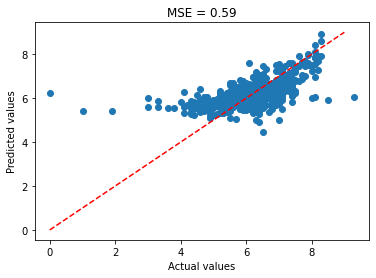

In [27]:

c=PolynomialFeatures(2)
x_train=c.fit_transform(X_Train)
x_test=c.transform(X_Test)
lr=LinearRegression()
lr.fit(x_train,Y_Train)
y_pred_train=lr.predict(x_train)
y_pred_test=lr.predict(x_test)

r2 = metrics.r2_score(Y_Test, y_pred_test)

print("Train error  "+str(mean_squared_error(Y_Train,y_pred_train)))
print("Testing error  "+str(mean_squared_error(Y_Test,y_pred_test)))
print('R2 For Testing:', r2)

plt.scatter(Y_Test, y_pred_test)
plt.plot(np.arange(0, 10), np.arange(0, 10), color='r', linestyle='--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('MSE = {:.2f}'.format(mean_squared_error(Y_Test,y_pred_test)))
plt.show()

save_model(c, 'PolynomialFeatures_model.pkl')
save_model(lr, 'LinearRegression_model.pkl')


### Support Vector Regression

Mean Square Error For Train: 0.5697172601023934
Mean Square Error For Testing: 0.6427362601284662
R2 For Testing: 0.3285662231667512


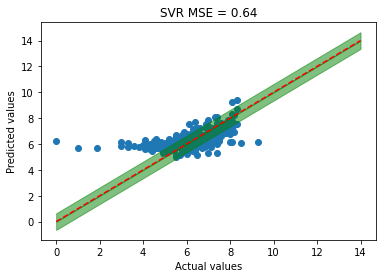

In [28]:

model = SVR(kernel='linear', C=1.0, epsilon=0.1)
model.fit(X_Train, Y_Train.ravel())
Y_pred= model.predict(X_Test)
Y_pred_train= model.predict(X_Train)
meanSqErr = mean_squared_error(Y_Test, Y_pred)
meanSqErr_train = mean_squared_error(Y_Train, Y_pred_train)

r2 = metrics.r2_score(Y_Test, Y_pred)

print('Mean Square Error For Train:', meanSqErr_train)
print('Mean Square Error For Testing:', meanSqErr)
print('R2 For Testing:', r2)

plt.scatter(Y_Test, Y_pred)
plt.plot(np.arange(0, 15), np.arange(0, 15), color='r', linestyle='--')
plt.fill_between(np.arange(0, 15), np.arange(0, 15), np.arange(0, 15) - meanSqErr, color='green', alpha=0.5)
plt.fill_between(np.arange(0, 15), np.arange(0, 15), np.arange(0, 15) + meanSqErr, color='green', alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('SVR MSE = {:.2f}'.format(meanSqErr))
plt.show()


save_model(model, 'SVM_model.pkl')


## Test script

In [30]:
    
# Test script
def test_script(data, movies):

    data = pd.read_csv(data)
    X = data.iloc[:, :19] 
    Y = data['vote_average']
    movies = pd.read_csv(movies)

    X = join_columns(X, movies)

    X = nonModels_preprocessing_script(X)
    X = apply_encodings(X)

    rfe = load_feature_selection()
    X = rfe.transform(X)

    c = load_model('PolynomialFeatures_model.pkl')
    lr = load_model('LinearRegression_model.pkl')
    x_test = c.transform(X)
    y_pred_test = lr.predict(x_test)
    r2 = metrics.r2_score(Y, y_pred_test)
    print('R2: ', r2)
    print("Polynomial Reggression MSE Testing error: "+str(mean_squared_error(Y,y_pred_test)))

    model = load_model('SVM_model.pkl')
    Y_pred = model.predict(X)
    meanSqErr = mean_squared_error(Y, Y_pred)
    r2 = metrics.r2_score(Y, Y_pred)
    print('SVR MSE Testing error: ', meanSqErr)
    print('R2: ', r2)



    
        

# Test the model using a new CSV file
test_script('test.csv', 'movies-credit-students-train.csv')



c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['am', 'bs', 'ca', 'ce', 'co', 'km', 'mi', 'sa', 'si'] will be ignored
  .format(sorted(unknown, key=str)))
c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['Aruba', 'Libyan Arab Jamahiriya', 'Serbia'] will be ignored
  .format(sorted(unknown, key=str)))


R2:  0.38599048912136336
Polynomial Reggression MSE Testing error: 0.5877663446822016
SVR MSE Testing error:  0.6427362601284662
R2:  0.3285662231667512
